In [1]:
"""
UHID Essex County - Land Cover Analysis
Author: Samuel
Date: November 2025
Purpose: Process NLCD data to quantify impervious surfaces and tree canopy

This notebook:
1. Loads NLCD impervious surface and tree canopy data
2. Aligns with LST grid from previous analysis
3. Calculates land cover metrics per grid cell
4. Analyzes correlation with temperature
5. Exports aligned datasets for modeling
"""

# ============================================
# SETUP
# ============================================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/SharedFilesUHIDTeam')

print("✓ Drive mounted")

Mounted at /content/drive
✓ Drive mounted


In [2]:
# ============================================
# INSTALL & IMPORT LIBRARIES
# ============================================
print("\n=== Installing Packages ===")
!pip install rasterio geopandas matplotlib numpy scipy seaborn -q

import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Packages loaded")


=== Installing Packages ===
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 80.3 MB/s eta 0:00:00
✓ Packages loaded


In [3]:
# ============================================
# STEP 1: LOAD LAND COVER DATA
# ============================================
print("\n=== Loading Land Cover Data ===")

landcover_folder = Path('02_Land_Cover')

# Load impervious surface data
impervious_file = landcover_folder / 'nlcd_2019_impervious_essex.tif'
tree_canopy_file = landcover_folder / 'nlcd_2019_tree_canopy_essex.tif'

print(f"\n📊 Impervious Surface Data:")
with rasterio.open(impervious_file) as src:
    impervious = src.read(1).astype(float)
    impervious_profile = src.profile

    print(f"  File: {impervious_file.name}")
    print(f"  CRS: {src.crs}")
    print(f"  Dimensions: {src.width} x {src.height}")
    print(f"  Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
    print(f"  Value range: {np.nanmin(impervious):.1f}% - {np.nanmax(impervious):.1f}%")
    print(f"  Mean: {np.nanmean(impervious):.1f}%")

print(f"\n🌳 Tree Canopy Data:")
with rasterio.open(tree_canopy_file) as src:
    tree_canopy = src.read(1).astype(float)
    tree_profile = src.profile

    print(f"  File: {tree_canopy_file.name}")
    print(f"  CRS: {src.crs}")
    print(f"  Dimensions: {src.width} x {src.height}")
    print(f"  Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
    print(f"  Value range: {np.nanmin(tree_canopy):.1f}% - {np.nanmax(tree_canopy):.1f}%")
    print(f"  Mean: {np.nanmean(tree_canopy):.1f}%")


=== Loading Land Cover Data ===

📊 Impervious Surface Data:
  File: nlcd_2019_impervious_essex.tif
  CRS: PROJCS["IMAGINE GeoTIFF Support
ERDAS IMAGINE 2018  16.5.0.596
Projection = Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Dimensions: 850 x 887
  Resolution: 30.0m x 30.0m
  Value range: 0.0% - 100.0%
  Mean: 29.7%

🌳 Tree Canopy Data:
  File: nlcd_2019_tree_canopy_essex.tif
  CRS: PROJCS["IMAGINE GeoTIFF Support
ERDAS IMAGINE 2018  16.5.0.596
Projection = Albers Conica

In [4]:
# ============================================
# STEP 2: LOAD LST DATA FOR ALIGNMENT
# ============================================
print("\n=== Loading LST Data for Alignment ===")

lst_file = Path('01_Satellite_LST/processed/Essex_LST_Celsius.tif')

if lst_file.exists():
    with rasterio.open(lst_file) as src:
        lst_celsius = src.read(1)
        lst_profile = src.profile
        lst_bounds = src.bounds
        lst_crs = src.crs

        # Replace nodata with NaN
        lst_celsius[lst_celsius == -9999] = np.nan

        print(f"✓ LST grid loaded")
        print(f"  Dimensions: {src.width} x {src.height}")
        print(f"  Resolution: {src.res[0]:.1f}m")
        print(f"  CRS: {lst_crs}")
else:
    print("✗ LST file not found. Please run 01_LST_Analysis.ipynb first")
    lst_celsius = None


=== Loading LST Data for Alignment ===
✓ LST grid loaded
  Dimensions: 664 x 667
  Resolution: 30.0m
  CRS: EPSG:32618


In [5]:
# ============================================
# STEP 3: ALIGN LAND COVER TO LST GRID
# ============================================
print("\n=== Aligning Land Cover Data to LST Grid ===")

def align_to_reference(data_file, reference_profile):
    """
    Reproject and resample data to match reference grid
    """
    with rasterio.open(data_file) as src:
        data = src.read(1)

        # Create output array matching reference
        aligned = np.empty(
            (reference_profile['height'], reference_profile['width']),
            dtype=np.float32
        )

        # Reproject to match LST grid
        reproject(
            source=data,
            destination=aligned,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=reference_profile['transform'],
            dst_crs=reference_profile['crs'],
            resampling=Resampling.bilinear
        )

        # Replace 0 with NaN (assuming 0 is nodata)
        aligned[aligned == 0] = np.nan

        return aligned

if lst_celsius is not None:
    print("Aligning impervious surface...")
    impervious_aligned = align_to_reference(impervious_file, lst_profile)

    print("Aligning tree canopy...")
    tree_canopy_aligned = align_to_reference(tree_canopy_file, lst_profile)

    print("✓ All datasets aligned to LST grid")

    # Calculate vegetation index (inverse of impervious)
    vegetation_pct = 100 - impervious_aligned
    vegetation_pct[vegetation_pct < 0] = 0


=== Aligning Land Cover Data to LST Grid ===
Aligning impervious surface...
Aligning tree canopy...
✓ All datasets aligned to LST grid


In [6]:
# ============================================
# STEP 4: CALCULATE LAND COVER STATISTICS
# ============================================
print("\n=== Land Cover Statistics ===")

if lst_celsius is not None:
    print(f"\n📊 Impervious Surface:")
    print(f"  Mean: {np.nanmean(impervious_aligned):.1f}%")
    print(f"  Range: {np.nanmin(impervious_aligned):.1f}% - {np.nanmax(impervious_aligned):.1f}%")
    print(f"  High (>75%): {np.sum(impervious_aligned > 75) / np.sum(~np.isnan(impervious_aligned)) * 100:.1f}%")

    print(f"\n🌳 Tree Canopy:")
    print(f"  Mean: {np.nanmean(tree_canopy_aligned):.1f}%")
    print(f"  Range: {np.nanmin(tree_canopy_aligned):.1f}% - {np.nanmax(tree_canopy_aligned):.1f}%")
    print(f"  High (>50%): {np.sum(tree_canopy_aligned > 50) / np.sum(~np.isnan(tree_canopy_aligned)) * 100:.1f}%")

    print(f"\n🌡️ LST by Land Cover:")

    # Temperature by impervious surface category
    low_imp = lst_celsius[(impervious_aligned < 25) & ~np.isnan(lst_celsius)]
    med_imp = lst_celsius[(impervious_aligned >= 25) & (impervious_aligned < 75) & ~np.isnan(lst_celsius)]
    high_imp = lst_celsius[(impervious_aligned >= 75) & ~np.isnan(lst_celsius)]

    print(f"  Low impervious (<25%): {np.nanmean(low_imp):.1f}°C")
    print(f"  Medium impervious (25-75%): {np.nanmean(med_imp):.1f}°C")
    print(f"  High impervious (>75%): {np.nanmean(high_imp):.1f}°C")
    print(f"  Temperature difference: {np.nanmean(high_imp) - np.nanmean(low_imp):.1f}°C")



=== Land Cover Statistics ===

📊 Impervious Surface:
  Mean: 57.8%
  Range: 0.0% - 100.0%
  High (>75%): 35.2%

🌳 Tree Canopy:
  Mean: 70.5%
  Range: 0.0% - 100.0%
  High (>50%): 69.7%

🌡️ LST by Land Cover:
  Low impervious (<25%): 34.0°C
  Medium impervious (25-75%): 38.3°C
  High impervious (>75%): 40.2°C
  Temperature difference: 6.2°C


In [7]:
# ============================================
# STEP 5: CORRELATION ANALYSIS
# ============================================
print("\n=== Correlation Analysis ===")

if lst_celsius is not None:
    # Create flat arrays (removing NaN)
    mask = ~np.isnan(lst_celsius) & ~np.isnan(impervious_aligned) & ~np.isnan(tree_canopy_aligned)

    lst_flat = lst_celsius[mask]
    imp_flat = impervious_aligned[mask]
    tree_flat = tree_canopy_aligned[mask]

    # Calculate correlations
    corr_imp = np.corrcoef(lst_flat, imp_flat)[0, 1]
    corr_tree = np.corrcoef(lst_flat, tree_flat)[0, 1]

    print(f"\n📈 Pearson Correlations with LST:")
    print(f"  Impervious surface: r = {corr_imp:.3f}")
    print(f"  Tree canopy: r = {corr_tree:.3f}")

    if abs(corr_imp) > 0.5:
        print(f"  ✓ Strong positive correlation with impervious surfaces")
    if abs(corr_tree) < -0.3:
        print(f"  ✓ Negative correlation with tree canopy (trees = cooling)")



=== Correlation Analysis ===

📈 Pearson Correlations with LST:
  Impervious surface: r = 0.413
  Tree canopy: r = -0.158



=== Creating Visualizations ===
✓ Visualization saved: LandCover_Analysis_Essex_County.png


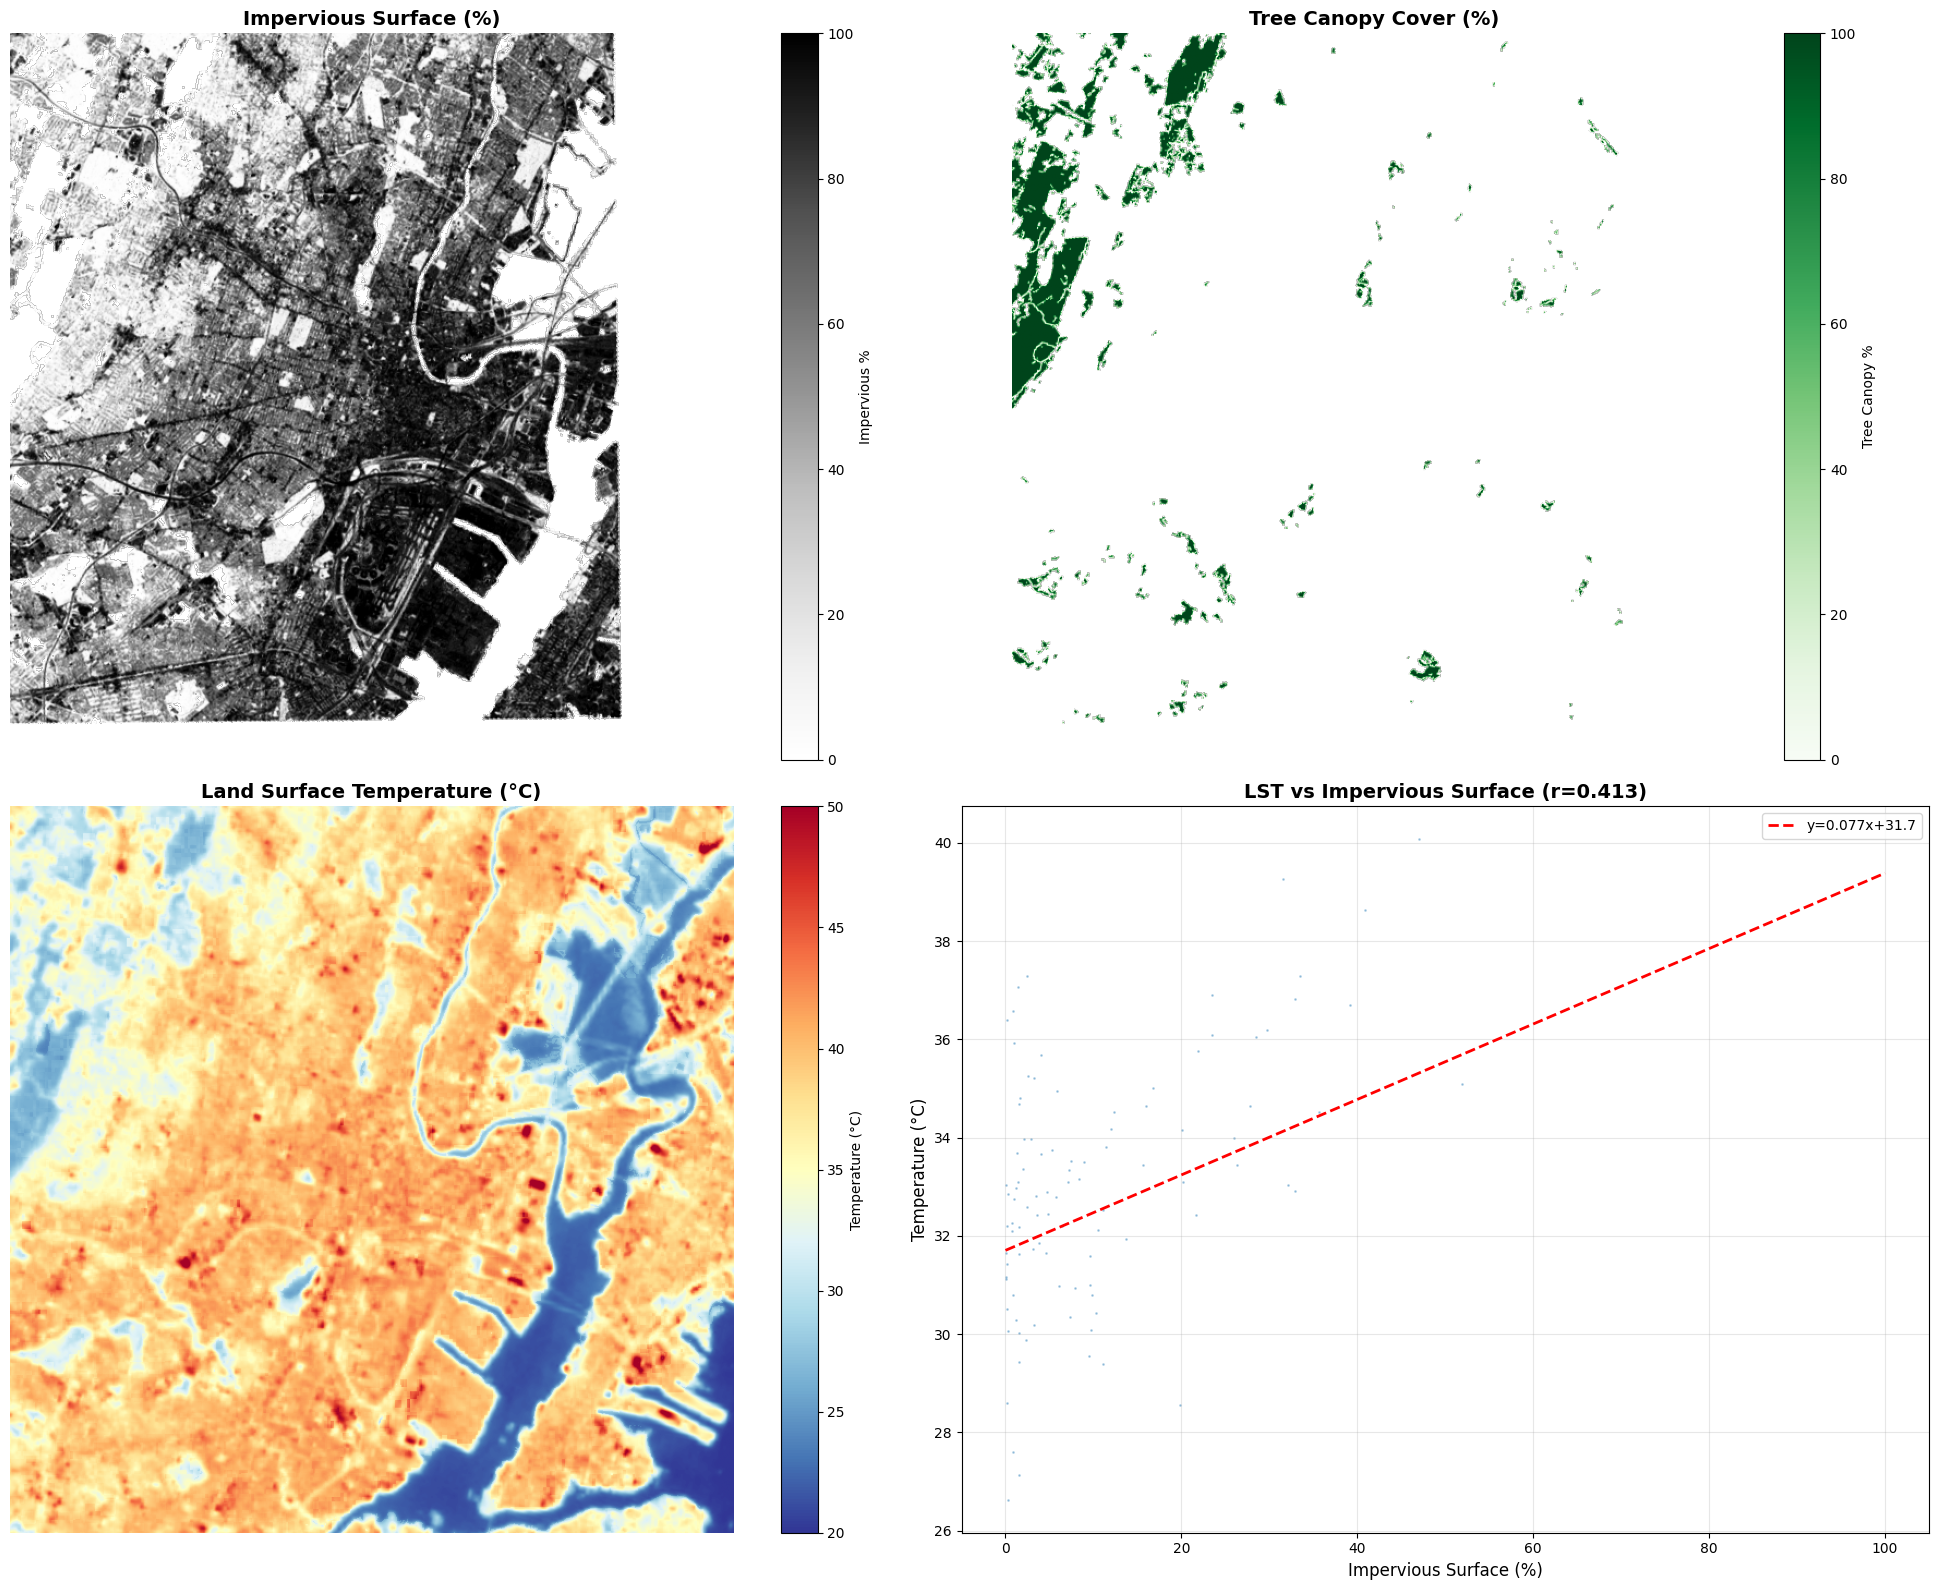

In [8]:
# ============================================
# STEP 6: VISUALIZATIONS
# ============================================
print("\n=== Creating Visualizations ===")

if lst_celsius is not None:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Plot 1: Impervious Surface
    im1 = axes[0, 0].imshow(impervious_aligned, cmap='Greys', vmin=0, vmax=100)
    axes[0, 0].set_title('Impervious Surface (%)', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], label='Impervious %')

    # Plot 2: Tree Canopy
    im2 = axes[0, 1].imshow(tree_canopy_aligned, cmap='Greens', vmin=0, vmax=100)
    axes[0, 1].set_title('Tree Canopy Cover (%)', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], label='Tree Canopy %')

    # Plot 3: LST (for comparison)
    im3 = axes[1, 0].imshow(lst_celsius, cmap='RdYlBu_r', vmin=20, vmax=50)
    axes[1, 0].set_title('Land Surface Temperature (°C)', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], label='Temperature (°C)')

    # Plot 4: Scatter plot - Impervious vs LST
    axes[1, 1].scatter(imp_flat[::100], lst_flat[::100], alpha=0.3, s=1)
    axes[1, 1].set_xlabel('Impervious Surface (%)', fontsize=12)
    axes[1, 1].set_ylabel('Temperature (°C)', fontsize=12)
    axes[1, 1].set_title(f'LST vs Impervious Surface (r={corr_imp:.3f})', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)

    # Add trend line
    z = np.polyfit(imp_flat, lst_flat, 1)
    p = np.poly1d(z)
    x_line = np.array([0, 100])
    axes[1, 1].plot(x_line, p(x_line), "r--", linewidth=2, label=f'y={z[0]:.3f}x+{z[1]:.1f}')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('LandCover_Analysis_Essex_County.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved: LandCover_Analysis_Essex_County.png")
    plt.show()

In [9]:
# ============================================
# STEP 7: EXPORT ALIGNED DATASETS
# ============================================
print("\n=== Exporting Aligned Datasets ===")

if lst_celsius is not None:
    output_folder = Path('02_Land_Cover/processed')
    output_folder.mkdir(exist_ok=True)

    # Update profile for exports
    export_profile = lst_profile.copy()
    export_profile.update(dtype=rasterio.float32, count=1, nodata=-9999)

    # Export impervious surface
    imp_export = np.where(np.isnan(impervious_aligned), -9999, impervious_aligned)
    with rasterio.open(output_folder / 'Essex_Impervious_Aligned.tif', 'w', **export_profile) as dst:
        dst.write(imp_export.astype(rasterio.float32), 1)
    print("✓ Exported: Essex_Impervious_Aligned.tif")

    # Export tree canopy
    tree_export = np.where(np.isnan(tree_canopy_aligned), -9999, tree_canopy_aligned)
    with rasterio.open(output_folder / 'Essex_TreeCanopy_Aligned.tif', 'w', **export_profile) as dst:
        dst.write(tree_export.astype(rasterio.float32), 1)
    print("✓ Exported: Essex_TreeCanopy_Aligned.tif")

    # Export combined statistics CSV
    stats_df = pd.DataFrame({
        'Metric': [
            'Mean Impervious %',
            'Mean Tree Canopy %',
            'Mean LST (°C)',
            'LST-Impervious Correlation',
            'LST-TreeCanopy Correlation',
            'Temp Diff (High vs Low Impervious)'
        ],
        'Value': [
            np.nanmean(impervious_aligned),
            np.nanmean(tree_canopy_aligned),
            np.nanmean(lst_celsius),
            corr_imp,
            corr_tree,
            np.nanmean(high_imp) - np.nanmean(low_imp)
        ]
    })
    stats_df.to_csv(output_folder / 'LandCover_Statistics.csv', index=False)
    print("✓ Exported: LandCover_Statistics.csv")



=== Exporting Aligned Datasets ===
✓ Exported: Essex_Impervious_Aligned.tif
✓ Exported: Essex_TreeCanopy_Aligned.tif
✓ Exported: LandCover_Statistics.csv
